# Projeto Porto Inteligente
#### Union Squad – Daniel Rocha, Mateus Pinheiro, Letícia Fiorito, Wallys Souza, Everton Arruda
Este projeto visa ajudar na virtualização da cadeia logística integrada dos portos brasileiros

### Importando pacotes e fazendos ajustes:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import palettable
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)

import matplotlib.style
import matplotlib as mpl
for m,n in zip(['grid.color','axes.titlecolor','axes.labelcolor','xtick.color','ytick.color','axes.titlesize',
    'figure.figsize','legend.framealpha'],['white','white','white','white','white','20.0','13.0, 8.0','0.8']):
    mpl.rcParams[m] = n

### Importando os dados de estadia:

In [3]:
stays = pd.read_csv('/Users/pedrocerbino/Downloads/ESTADIA/Estadia.csv',sep=';')
for i in ['Atracação Prevista','Atracação Efetiva','Desatracação Prevista','Desatracação Efetiva']:
    stays[i] = pd.to_datetime(stays[i],errors='coerce')
stays['Local(is) Atracação (área do porto > berço > cabeço)'] = [i.split(' > ')[1] for i in stays[
    'Local(is) Atracação (área do porto > berço > cabeço)']]
stays.rename(columns={'Local(is) Atracação (área do porto > berço > cabeço)':'Berço'},inplace=True)
stays.drop(columns=['Local(is) e Data(s) Reatracação (área do porto > berço > ca'],inplace=True)
stays['Código Bitrigrama'] = [i.split(' - ')[0] for i in stays['Porto de estadia atual']]
stays.head(2)

,Número do DUV,Estadia Off-Shore,Porto de estadia atual,Atracação Prevista,Atracação Efetiva,Desatracação Prevista,Desatracação Efetiva,Berço,Bandeira da Embarcação,Área de Navegação,Finalidade da Embarcação,Tipo de Embarcação,Motivo de Atracação,Tipo de Viagem Chegada,Tipo de Viagem Saída,Especialidade da Carga Predominante,Código Bitrigrama
0,8e0879c460c1314a25bea44f73974e3e,Não,BRRIO - RIO DE JANEIRO,2016-12-31 17:30:00,2017-01-01 07:20:00,2017-01-01 15:00:00,2017-01-01 16:00:00,2C21,Libéria,IMPORT/EXPORT/LONGO CURSO,Transporte de Contentores,Porta Contentor,Carga e Descarga,EXPORTAÇÃO/LONGO CURSO,IMPORTAÇÃO/LONGO CURSO,Conteiner,BRRIO
1,77a23e1146e03847763ea5aaa70ecbc3,Não,BRSSZ - SANTOS,2017-01-01 02:00:00,2017-01-01 08:30:00,2017-02-01 01:00:00,2017-02-01 03:15:00,EPORT II,Libéria,IMPORT/EXPORT/LONGO CURSO,Transporte de Contentores,Porta Contentor,Carga e Descarga,EXPORTAÇÃO/LONGO CURSO,IMPORTAÇÃO/LONGO CURSO,Conteiner,BRSSZ


In [4]:
stays['Porto de estadia atual'].value_counts(True)[:15]

BRSSZ - SANTOS                  0.178840
BRRIO - RIO DE JANEIRO          0.140936
BRPNG - PARANAGUA               0.079988
BRRIG - RIO GRANDE              0.059064
BRSUA - SUAPE                   0.055845
                                  ...   
BRNTR - NITERÓI                 0.024928
BRPEC - PECEM                   0.023593
BRARB - ARATU                   0.021285
BRVDC - VILA DO CONDE           0.020274
BRSFS - SAO FRANCISCO DO SUL    0.016494
Name: Porto de estadia atual, Length: 15, dtype: float64

In [5]:
dex = stays['Atracação Efetiva'].astype('datetime64[ns]')
data = pd.DataFrame({'Date':dex.dt.date,'Hour':dex.dt.hour,'Data':(stays
    ['Atracação Prevista'] - stays['Atracação Efetiva']).astype('timedelta64[h]')}).groupby(
    ['Date','Hour'],as_index=False).mean()
data['Média Diária'] = data.Data.rolling(24).mean()
data.set_index(data.Date,inplace=True)
data.drop(columns=['Date'],inplace=True)
data

,Hour,Data,Média Diária
Date,,,
2017-01-01,7,-14.000000,NaN
2017-01-01,8,-34.500000,NaN
2017-01-01,9,-289.000000,NaN
2017-01-01,10,-16.666667,NaN
2017-01-01,11,-14.200000,NaN
...,...,...,...
2019-12-30,18,-53.750000,-8.045337
2019-12-30,19,-9.500000,-7.857837
2019-12-30,20,-16.666667,-7.302282


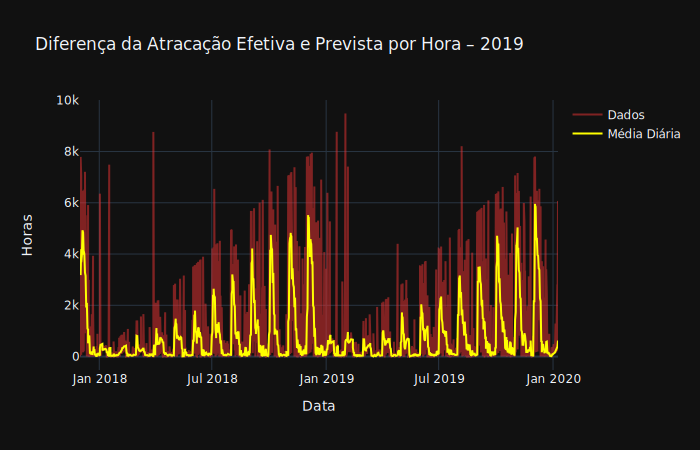

In [204]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.Data[-8330:].index, y=data.Data[-8330:].values,
                         line=dict(color='rgba(240, 52, 52, 0.5)'), name='Dados'))
fig.add_trace(go.Scatter(x=data.Data[-8330:].index, y=data.Data[-8330:].rolling(24).mean().values,
                         line=dict(color='yellow'), name='Média Diária'))
fig.update_layout(template='plotly_dark')
fig.update_layout(title='Diferença da Atracação Efetiva e Prevista por Hora – 2019',
                  template='plotly_dark',
                  xaxis_title='Data',
                  yaxis_title='Horas')
# fig.show();
# fig.write_html("/Users/pedrocerbino/Downloads/Graph_2.html")
plotly.io.orca.config.executable = '/Users/pedrocerbino/opt/anaconda3/bin/orca'
fig.show('svg');

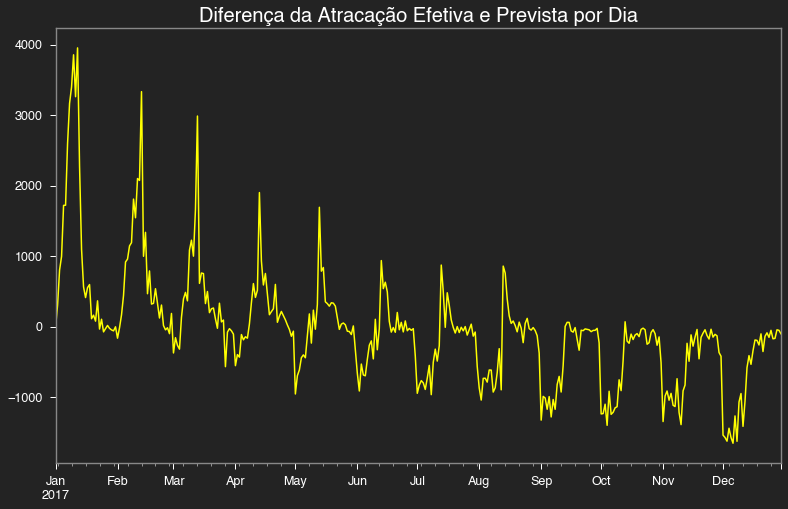

In [7]:
pd.Series(data=(stays['Atracação Prevista'] - stays['Atracação Efetiva']).astype(
    'timedelta64[h]').values, index=stays['Atracação Efetiva'].astype(
    'datetime64[D]').values).groupby(level=0).mean()[:364].plot(color='yellow')
plt.title('Diferença da Atracação Efetiva e Prevista por Dia');

### Verificando a distribuição dos dados

In [8]:
stays['Finalidade da Embarcação'].value_counts(normalize=True) 

Transporte de Contentores       0.240262
Transporte de Granel Sólido     0.237130
Transporte de Granel Líquido    0.187536
Apoio Marítimo                  0.142907
Transporte de Carga Geral       0.071890
                                  ...   
Dragagem                        0.001235
Lançamento de Cabos             0.001173
Lazer                           0.000200
Pesca                           0.000100
Recreio                         0.000075
Name: Finalidade da Embarcação, Length: 18, dtype: float64

In [9]:
stays['Tipo de Embarcação'].value_counts(normalize=True) 

Graneleiro                        0.275970
Porta Contentor                   0.249395
Supply                            0.101422
Petroleiro                        0.088908
Carga Geral                       0.076357
                                    ...   
Navio sonda                       0.000050
Passageiros / Roll-On Roll-Off    0.000050
Navio cisterna                    0.000050
Plataforma                        0.000037
Ferry Boat                        0.000025
Name: Tipo de Embarcação, Length: 20, dtype: float64

In [10]:
stays['Especialidade da Carga Predominante'].value_counts(normalize=True) 

Granel Sólido     0.277218
Conteiner         0.270593
Granel Líquido    0.211876
Carga Geral       0.208543
Ro-Ro             0.031770
Name: Especialidade da Carga Predominante, dtype: float64

In [11]:
stays[stays['Especialidade da Carga Predominante']=='Granel Sólido'][
    'Porto de estadia atual'].value_counts()

BRSSZ - SANTOS                                                 3703
BRPNG - PARANAGUA                                              2135
BRRIG - RIO GRANDE                                             1670
BRPMA001 - PONTA DA MADEIRA - VALE                             1091
BRARE - AREIA BRANCA (TERMISA)                                 1089
                                                               ... 
BRADR - ANGRA DOS REIS                                            1
BRARB009 - TRBA - TERMINAL DE REGAISEFICAÇÃO DE GAS NATURAL       1
BRVIX008 - CIA PORTUARIA VILA VELHA - CPVV - ES                   1
BRARB003 - DOW BRASIL - ARATU - BA                                1
BRARB004 - FORD MOTOR - ARATU - BA                                1
Name: Porto de estadia atual, Length: 64, dtype: int64

In [12]:
stays[stays['Especialidade da Carga Predominante']=='Granel Sólido'].head(2)

,Número do DUV,Estadia Off-Shore,Porto de estadia atual,Atracação Prevista,Atracação Efetiva,Desatracação Prevista,Desatracação Efetiva,Berço,Bandeira da Embarcação,Área de Navegação,Finalidade da Embarcação,Tipo de Embarcação,Motivo de Atracação,Tipo de Viagem Chegada,Tipo de Viagem Saída,Especialidade da Carga Predominante,Código Bitrigrama
6,68ef5810d04da2dc637f25cec11ea587,Não,BRVDC - VILA DO CONDE,2016-12-30 13:00:00,2017-01-01 10:35:00,2017-03-01 20:00:00,2017-03-01 18:00:00,301,Malta,IMPORT/EXPORT/LONGO CURSO,Transporte de Granel Sólido,Graneleiro,Descarga,EXPORTAÇÃO/LONGO CURSO,IMPORTAÇÃO/LONGO CURSO,Granel Sólido,BRVDC
25,84f60f736a34d63ba89d782d793def7d,Não,BRSSZ - SANTOS,2017-01-01 20:54:00,2017-01-01 17:35:00,2017-03-01 01:00:00,2017-03-01 06:50:00,Arm 20/21,"Marshall, Ilhas",EXPORTAÇÃO/LONGO CURSO,Transporte de Granel Sólido,Graneleiro,Carga,EXPORTAÇÃO/LONGO CURSO,NÃO INFORMADO,Granel Sólido,BRSSZ


### Analisando para cargas e tipos de navios

In [13]:
dex = stays['Atracação Efetiva'].astype('datetime64[ns]')
data = pd.DataFrame({'Date':dex.dt.date,'Hour':dex.dt.hour,
            'Especialidade da Carga Predominante':stays['Especialidade da Carga Predominante'],
    'Data':(stays
    ['Atracação Prevista'] - stays['Atracação Efetiva']).astype('timedelta64[h]')}).groupby(
    ['Especialidade da Carga Predominante'],as_index=False).mean()
data.drop(columns=['Hour'],inplace=True)
data.sort_values('Data',ascending=False,inplace=True)
data

,Especialidade da Carga Predominante,Data
4,Ro-Ro,24.886994
1,Conteiner,-0.751840
3,Granel Sólido,-81.962557
2,Granel Líquido,-95.375791
0,Carga Geral,-95.991419


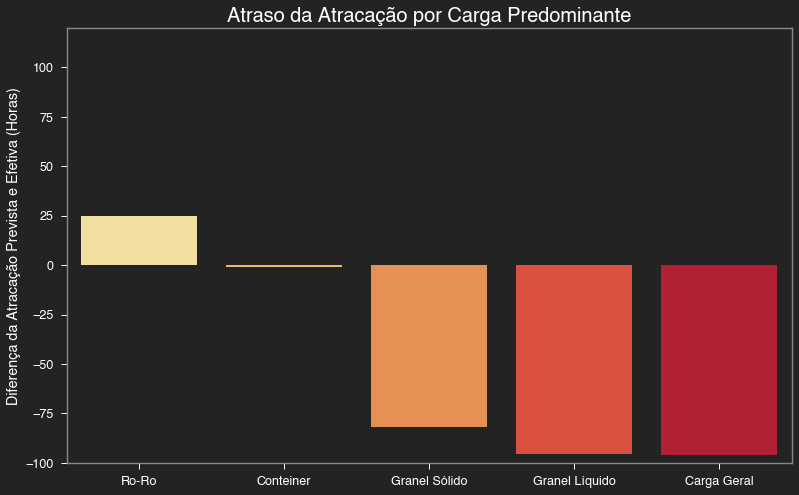

In [14]:
sns.barplot(data=data.sort_values(['Data'])[:10][-1::-1],x='Especialidade da Carga Predominante',
            y='Data',palette='YlOrRd')
plt.title('Atraso da Atracação por Carga Predominante')
plt.ylabel('Diferença da Atracação Prevista e Efetiva (Horas)')
plt.xlabel('')
plt.ylim(-100,120,10);

In [15]:
dex = stays['Atracação Efetiva'].astype('datetime64[ns]')
data = pd.DataFrame({'Date':dex.dt.date,'Hour':dex.dt.hour,
                     'Tipo de Embarcação':stays['Tipo de Embarcação'],'Data':(stays
    ['Atracação Prevista'] - stays['Atracação Efetiva']).astype('timedelta64[h]')}).groupby(
    ['Tipo de Embarcação'],as_index=False).mean()
data.drop(columns=['Hour'],inplace=True)
data.sort_values('Data',ascending=False,inplace=True)
data

,Tipo de Embarcação,Data
1,Carga refrigerada,36.266129
18,Roll-On Roll-Off,9.992204
8,Passageiro,2.144208
2,Ferry Boat,0.000000
15,Porta Contentor,-2.858965
...,...,...
11,Pesqueiro,-223.791667
7,Outras embarcações,-223.896208
9,Passageiro / Carga Geral,-256.070796
5,Navio cisterna,-824.000000


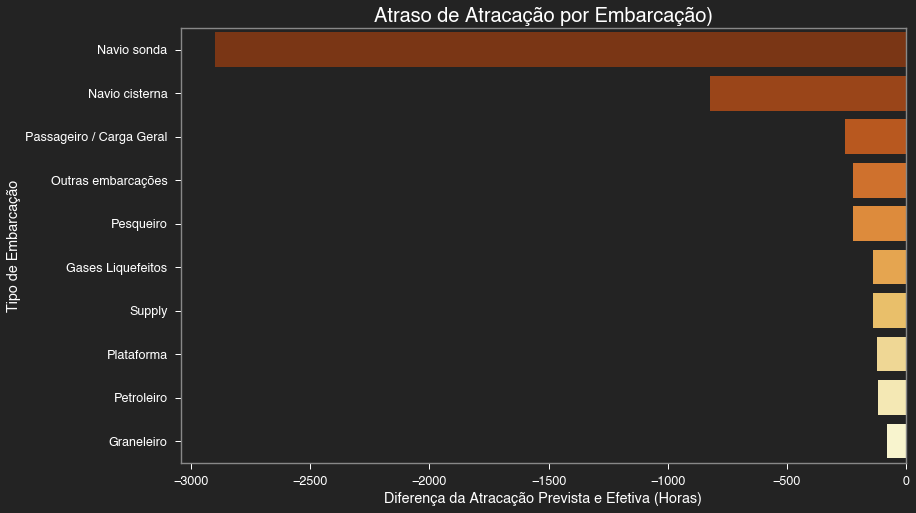

In [16]:
sns.barplot(data=data.sort_values(['Data'])[:10],y='Tipo de Embarcação',x='Data',
            palette='YlOrBr_r')
plt.xlabel('Diferença da Atracação Prevista e Efetiva (Horas)')
plt.title('Atraso de Atracação por Embarcação)');

In [17]:
data = pd.Series(data=(stays['Atracação Prevista'] - stays['Atracação Efetiva']).astype(
    'timedelta64[h]').values,index=stays['Atracação Efetiva'].astype(
    'datetime64[D]').values).groupby(level=0).mean().rolling(7).mean()

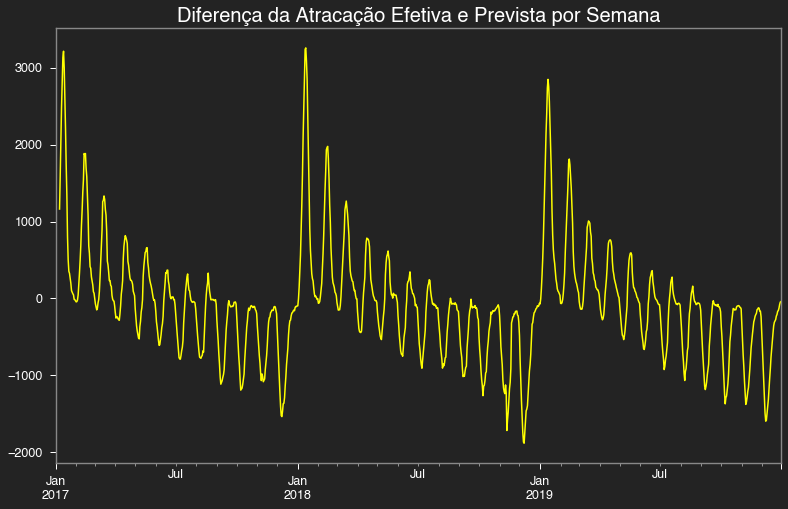

In [18]:
data.plot(color='yellow')
plt.title('Diferença da Atracação Efetiva e Prevista por Semana');

## 1. Modelo de Previsão da Diferença entre Atracação Prevista e Efetiva
Aplicamos um algoritmo estatístico de sazonalidade múltipla para prever os erros de estimativa do horário de atracação. Com base nessas informações, os agentes podem reavaliar as previsões realizadas e otimizá-las, além de terem uma ferramenta que facilita a tomada de decisão sobre como otimizar a logística, visto que o modelo dá visibilidade de quais dias possuem mais erros.

In [19]:
y_to_train = data.dropna()[:-219]
y_to_test = data.dropna()[-219:]
y_to_train

2017-01-07    1162.397755
2017-01-08    1615.443552
2017-01-09    2057.181255
2017-01-10    2493.141557
2017-01-11    2816.599172
                 ...     
2019-05-21     212.353014
2019-05-22     139.339032
2019-05-23     133.484392
2019-05-24      96.663476
2019-05-25      81.504059
Length: 869, dtype: float64

In [20]:
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(30.5,365.25))
model = estimator.fit(y_to_train)
# Forecast 219 days ahead 
y_forecast = model.forecast(steps=219)

In [206]:
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [ 30.5  365.25]
Seasonal harmonics [ 2 35]
ARMA errors (p, q): (3, 3)
Smoothing (Alpha): 1.409434
Seasonal Parameters (Gamma): [-3.99182804e-05  1.61657257e-04 -6.85520071e-05  6.23482384e-05]
AR coefficients [-6.85520071e-05  6.23482384e-05  4.01021130e-01]
MA coefficients [-0.47009046  0.15974905 -0.67132724]
Seed vector [ -65.84179849   71.08204258   84.63306592   -1.6914227   -23.8334169
  239.9540269   155.50494505  138.65114607  129.55613588  154.11923757
  157.15060394  150.53883312  161.47029352  164.19899294  199.40862993
  308.92877215 -340.41801023  -93.57270194  -49.07784776  -24.19882026
   11.24588792   59.23792582   47.33020367   15.06387729    2.35647003
   -4.60766832   -4.17281419   38.36138803 -260.83409426  -42.61866888
  -20.60177274  -13.04605116   -4.63079299    4.32709255  -12.69598824
  -16.13343534  -22.74035275  -21.68324577  -20.57994248  -35.91510078
  483.85822823  283.6788362   

### Validando o Modelo:

In [22]:
# calculate MAE between expected and predicted last 219 observations
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse
mae = mean_absolute_error(y_to_test, y_forecast)
rmse_1 = rmse(y_to_test, y_forecast)
mape = np.median(np.abs((y_to_test - y_forecast) / y_to_test)) * 100
print('MAE: %.2f' % mae)
print('RMSE: %.2f' % rmse_1)
print('MAPE: %.2f' % mape + '%')
accuracy = 100 - mape
print('Accuracy: %.2f' % accuracy + '%')

MAE: 100.54
RMSE: 139.01
MAPE: 28.41%
Accuracy: 71.59%


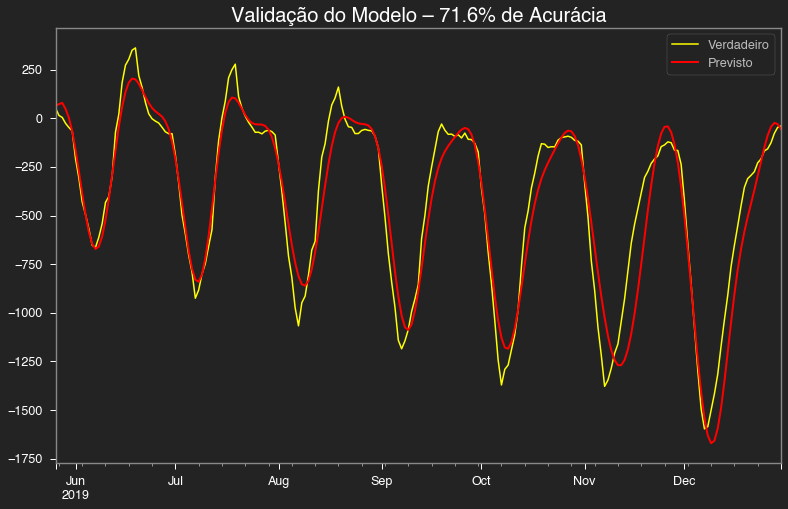

In [23]:
# plot expected vs actual
plt.figure(figsize=(13,8))
y_to_test.plot(label='Verdadeiro',color='yellow')
pd.Series(data=y_forecast,index=y_to_test.index).plot(label='Previsto',lw=2,color='red')
plt.title('Validação do Modelo – 71.6% de Acurácia',size=20,color='w')
plt.xticks(color='w')
plt.yticks(color='w')
plt.xlabel('')
plt.legend();

### Prevendo os dados futuros:

In [24]:
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(30.5,365.25))
model = estimator.fit(data.dropna())
# Forecast 219 days ahead 
y_forecast = model.forecast(steps=219)

In [25]:
import datetime
date_list=[data.dropna().index[-1] + datetime.timedelta(days=x) for x in range(len(y_forecast)+1)]

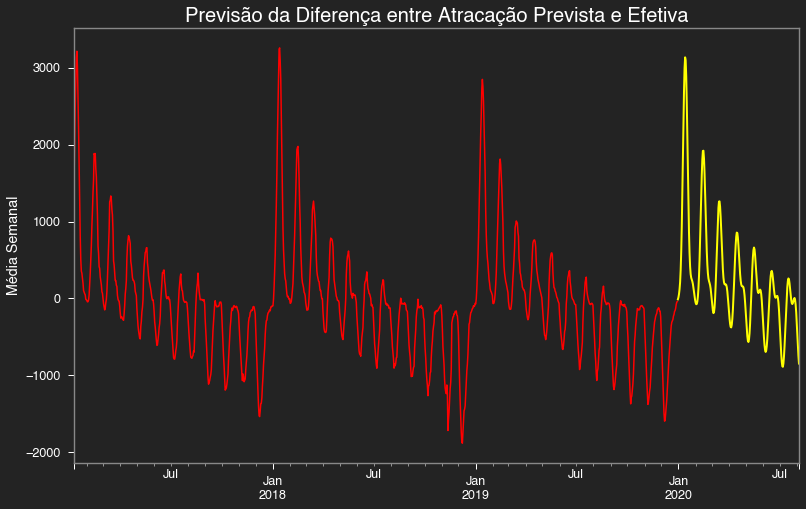

In [26]:
# plot expected vs actual
plt.figure(figsize=(13,8))
data.dropna().plot(label='Série Histórica',color='red')
pd.Series(data=y_forecast,index=date_list[1:]).plot(label='Previsão',lw=2,color='yellow')
plt.title('Previsão da Diferença entre Atracação Prevista e Efetiva',size=20,color='w')
plt.xticks(color='w')
plt.yticks(color='w')
plt.xlabel('')
plt.ylabel('Média Semanal');

### Analisando o Fundeadouro

In [28]:
fundeadouro = pd.read_csv('/Users/pedrocerbino/Downloads/Fundeadouro_Entrada_Sa¡da.csv',sep=';')
for i in ['Data Entrada Fundeio','Data Saída Fundeio']:
    fundeadouro[i] = pd.to_datetime(fundeadouro[i],utc=True)
fundeadouro['Data Entrada Fundeio'] = fundeadouro['Data Entrada Fundeio'].astype('datetime64[ns]')
fundeadouro['Data Saída Fundeio'] = fundeadouro['Data Saída Fundeio'].astype('datetime64[ns]')
fundeadouro['Dif Fund Saída Entrada'] = (fundeadouro['Data Saída Fundeio'] - fundeadouro[
                                        'Data Entrada Fundeio']).astype('timedelta64[h]')
fundeadouro['Dia Entrada'] = fundeadouro['Data Entrada Fundeio'].astype('datetime64[D]')
fundeadouro['Hora Entrada'] = [i.hour for i in fundeadouro['Data Entrada Fundeio'].astype(
                                                                                'datetime64[h]')]
fundeadouro['Dia Saída'] = fundeadouro['Data Saída Fundeio'].astype('datetime64[D]')
fundeadouro['Hora Saída'] = [i.hour for i in fundeadouro['Data Saída Fundeio'].astype(
                                                                                'datetime64[h]')]
fundeadouro = fundeadouro[fundeadouro['Dif Fund Saída Entrada']>0].copy()
fundeadouro.head(2)

,Número do DUV,Porto,Identificador do Fundeadouro,Descrição do Fundeadouro,Data Entrada Fundeio,Data Saída Fundeio,Motivo do Fundeio,Dif Fund Saída Entrada,Dia Entrada,Hora Entrada,Dia Saída,Hora Saída
0,78d669ec8be6b1e6a6c5278a28b75a55,BRPEC - PECEM,F2,Fundeadouro nº 2,2017-01-01 00:06:00,2017-01-18 21:18:00,Aguardando Atracação,429.0,2017-01-01,0,2017-01-18,21.0
1,d81615be85cfa964d759151fd4028202,BRSSZ - SANTOS,4,Externo Nº 4,2017-01-01 00:10:00,2017-01-13 04:00:00,Aguardando Atracação,291.0,2017-01-01,0,2017-01-13,4.0


In [29]:
fundeadouro.Porto.value_counts(True)[:15]

BRSSZ - SANTOS                  0.632549
BRSUA - SUAPE                   0.122234
BRARB - ARATU                   0.077113
BRPEC - PECEM                   0.057446
BRITJ - ITAJAÍ                  0.037458
                                  ...   
BRREC - RECIFE                  0.001018
BRPOA - PORTO ALEGRE - RS       0.000857
BRVIX - VITÓRIA                 0.000857
BRFOR - FORTALEZA (MUCURIPE)    0.000589
BRRIO - RIO DE JANEIRO          0.000375
Name: Porto, Length: 15, dtype: float64

In [30]:
dex = fundeadouro['Data Saída Fundeio'].astype('datetime64[ns]')
data = pd.DataFrame({'Date':dex.dt.date,'Hour':dex.dt.hour,'Data':(fundeadouro
['Data Saída Fundeio'] - fundeadouro['Data Entrada Fundeio']).astype('timedelta64[h]')}).groupby(
['Date','Hour'],as_index=False).mean()

data['Média Diária'] = data.Data.rolling(24).mean()
data.set_index(data.Date,inplace=True)
data.drop(columns=['Date'],inplace=True)
data = data[:-12]
data

,Hour,Data,Média Diária
Date,,,
2017-01-01,12,2.0,NaN
2017-01-01,13,3.0,NaN
2017-01-01,17,2.0,NaN
2017-01-01,19,15.0,NaN
2017-01-01,22,7.0,NaN
...,...,...,...
2020-01-06,13,285.0,255.895833
2020-01-06,17,372.0,265.854167
2020-01-08,1,2813.0,382.937500


### Plotando os dados de Fundeio

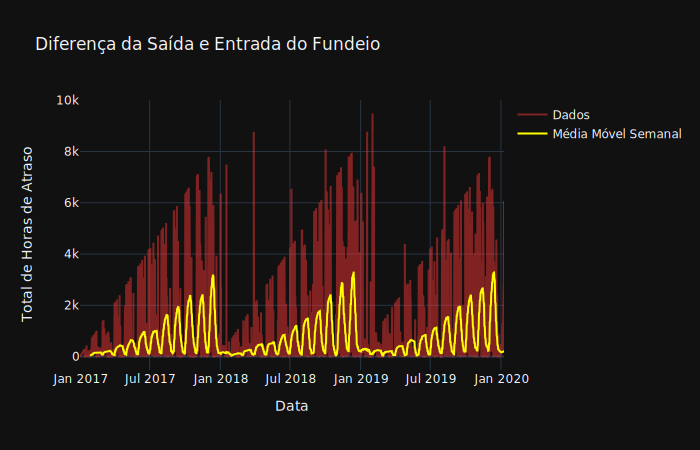

In [203]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.Data.index, y=data.Data.values,
                         line=dict(color='rgba(240, 52, 52, 0.5)'), name='Dados'))
fig.add_trace(go.Scatter(x=data.Data.rolling(24*7).mean().index, 
                         y=data.Data.rolling(24*7).mean().values,
                         line=dict(color='yellow'), name='Média Móvel Semanal'))
fig.update_layout(template='plotly_dark')
fig.update_layout(title='Diferença da Saída e Entrada do Fundeio',
                  template='plotly_dark',
                  xaxis_title='Data',
                  yaxis_title='Total de Horas de Atraso')
# fig.show();
# fig.write_html("/Users/pedrocerbino/Downloads/Graph_1.html")
plotly.io.orca.config.executable = '/Users/pedrocerbino/opt/anaconda3/bin/orca'
fig.show('svg');

## 2. Modelo de Previsão de Hiato no Fundeadouro
Usaremos o estudo de caso do Porto de Aratu para desenvolver um modelo estatístico de regressão linear para estimar o quanto um navio espera na barra antes de atracar. Além de realizar a previsão, o modelo também mostra quais as variáveis são mais importantes para essa estimação.

In [120]:
stays_porto = stays[stays['Código Bitrigrama'] == 'BRARB'].copy()
stays_porto['Atracação Efetiva'] = stays_porto['Atracação Efetiva'].astype('datetime64[ns]')
stays_porto['Atracação Prevista'] = stays_porto['Atracação Prevista'].astype('datetime64[ns]')
stays_porto['Dif Atrac Prev Efet'] = (stays_porto['Atracação Prevista'] - stays_porto[
                                        'Atracação Efetiva']).astype('timedelta64[h]')
stays_porto.head(2)

,Número do DUV,Estadia Off-Shore,Porto de estadia atual,Atracação Prevista,Atracação Efetiva,Desatracação Prevista,Desatracação Efetiva,Berço,Bandeira da Embarcação,Área de Navegação,Finalidade da Embarcação,Tipo de Embarcação,Motivo de Atracação,Tipo de Viagem Chegada,Tipo de Viagem Saída,Especialidade da Carga Predominante,Código Bitrigrama,Dif Atrac Prev Efet
18,bb5c79651845b42fd200ebf5a9f3eafb,Não,BRARB - ARATU,2016-12-24 03:00:00,2017-01-01 14:25:00,2017-04-01 05:00:00,2017-04-01 18:15:00,TGL 202,Panamá,IMPORT/EXPORT/LONGO CURSO,Transporte de Granel Líquido,Químico,Carga,EXPORTAÇÃO/LONGO CURSO,IMPORTAÇÃO/LONGO CURSO,Granel Líquido,BRARB,-204.0
30,2f733db496336d846eae0e412a9f98ea,Não,BRARB - ARATU,2016-12-29 17:00:00,2017-01-01 20:00:00,2017-02-01 23:00:00,2017-03-01 01:15:00,TGL 201,Brasil,IMPORT/EXPORT/CABOTAGEM,Transporte de Granel Líquido,Químico,Carga,EXPORTAÇÃO/CABOTAGEM,IMPORTAÇÃO/CABOTAGEM,Granel Líquido,BRARB,-75.0


### Dados de Chuva (Porto de Aratu):
Os dados foram coletado da por meio da API da INMET, que disponibiliza esses dados gratuitamente. Foram analisados os dados da estação pluviométrica mais próxima do porto.

In [121]:
import requests
r = requests.get('https://apitempo.inmet.gov.br/estacao/diaria/2017-01-01/2019-12-31/A456')
r = r.json()

In [122]:
porto_chuva = pd.DataFrame(r)[['DT_MEDICAO','CHUVA']]
porto_chuva.DT_MEDICAO = pd.to_datetime(porto_chuva.DT_MEDICAO)
porto_chuva.CHUVA = [0 if str(i) == 'None' else float(i) for i in porto_chuva.CHUVA]
porto_chuva.head(5)

,DT_MEDICAO,CHUVA
0,2017-01-01,0.0
1,2017-01-02,0.0
2,2017-01-03,0.0
3,2017-01-04,0.0
4,2017-01-05,0.0


### Dados de Marés (Porto de Aratu):
Os dados das marés foram coletados a partir do site do INPE, que registra os dados históricos que são produzidos pela Marinha.

In [123]:
def limpa_dados(database):
    """
    Eliminando colunas e linhas desnecessárias para a análise
    """
    database.drop(inplace=True,columns=[i for i in database.columns if 'Unnamed: ' in i])
    database.reset_index(inplace=True,drop=True)
    database.drop(index=list(range(0,14)),inplace=True)
    database.reset_index(inplace=True,drop=True)
    database = database.T.reset_index().copy()
    return database

In [124]:
def estrutura_dados(database):
    """
    Estruturando os dados para cada linha representar um dia, e cada coluna uma variável
    """
    cont = 0
    data_dict = {}
    for row in database.index:
        for col in database.columns[1:]:
            if '2020' in str(database[col][row]):
                cont += 1
                if cont <= 12:
                    col_name = '2017' + str(database[col][row]).split(' ')[0][4:]
                elif cont > 12:
                    col_name = '2018' + str(database[col][row]).split(' ')[0][4:]
                elif cont > 24:
                    col_name = '2019' + str(database[col][row]).split(' ')[0][4:]
                elif cont > 36:
                    col_name = '2020' + str(database[col][row]).split(' ')[0][4:]
                data_dict[col_name] = []
            else:
                try:
                    value_hour = str(database[col][row]).split(' ')[0]
                    value_tide = str(database[col][row]).split(' ')[2]
                    data_dict[col_name].append(value_hour)
                    data_dict[col_name].append(value_tide)
                except:
                    pass
    return data_dict

In [125]:
def entabela_dados(data_dict):
    """
    Transformando dados vazios em valores nulos para permitir estruturar em formato de tabela
    """
    for key in data_dict.keys():
        if len(data_dict[key]) != 16:
            max_iter = 16 - len(data_dict[key])
            for i in range(0,max_iter):
                data_dict[key].append(np.nan)
    return data_dict

In [126]:
def ajusta_dados(data_dict):
    """
    Ajustes para facilitar manuseio: transpondo a matriz e renomeando as colunas
    """
    database = pd.DataFrame(data_dict).T.copy()
    database.columns=sorted([str(i)+'_Tide' for i in range(1,9)]+[str(i)+'_Clock' for i 
                                                                                    in range(1,9)])
    return database

In [127]:
def preenche_dados(database,nome):
    """
    Preenchendo valores nulos na tabela com a última maré registrada
    """
    for row in database.index:
        for col in database.columns[-10:]:
            if str(database[col][row]) == 'nan':
                database[col][row] = database[str(int(col[0])-1)+col[1:]][row]
    for k in range(1,9):
        database[str(k)+'_Hour']=[i.hour for i in database[str(k)+'_Clock'].astype('datetime64[h]')]
    database.reset_index(inplace=True)
    database.rename(columns={'index':'Data'},inplace=True)
    database.Data = database.Data.astype('datetime64[D]')
    globals()[str(nome)] = database
    return database.head(2)

In [128]:
aratu = pd.read_excel('/Users/pedrocerbino/Downloads/Tábua de Marés - Porto de Aratu.xlsx')
preenche_dados(ajusta_dados(entabela_dados(estrutura_dados(limpa_dados(aratu)))),'porto_aratu')

,Data,1_Clock,1_Tide,2_Clock,2_Tide,3_Clock,3_Tide,4_Clock,4_Tide,5_Clock,5_Tide,6_Clock,6_Tide,7_Clock,7_Tide,8_Clock,8_Tide,1_Hour,2_Hour,3_Hour,4_Hour,5_Hour,6_Hour,7_Hour,8_Hour
0,2017-01-01,05:56,2.4,11:45,0.5,18:04,2.5,18:04,2.5,18:04,2.5,18:04,2.5,18:04,2.5,18:04,2.5,5,11,18,18,18,18,18,18
1,2017-01-02,00:06,0.4,06:38,2.3,12:23,0.6,18:49,2.4,18:49,2.4,18:49,2.4,18:49,2.4,18:49,2.4,0,6,12,18,18,18,18,18


### Consolidando tabelas distintas em uma única

In [129]:
merged = stays_porto.merge(fundeadouro[fundeadouro.Porto=='BRARB - ARATU'].drop(columns='Porto'))
porto_merged = merged.merge(porto_aratu,left_on=['Dia Entrada'],right_on=['Data'])
porto_merged = porto_merged.merge(porto_chuva,left_on=['Dia Entrada'],right_on=['DT_MEDICAO'])

### Construindo colunas contendo o horário de maré, e o nível de maré, mais próximo do de atracação

In [130]:
tide_hour, tide = [], []
for row in porto_merged.index:
    for m,n in zip(['one','two','three','four','five','six','seven','eight'],range(1,9)):
        globals()[m]=np.abs(porto_merged['Hora Entrada'][row]-porto_merged[str(n)+'_Hour'][row])
    lower = min(one,two,three,four,five,six,seven,eight)
    m_last = 'test'
    for m,n in zip(['one','two','three','four','five','six','seven','eight'],range(1,9)):
        if globals()[m] == lower and globals()[m] != m_last:
            tide_hour.append(porto_merged[str(n)+'_Hour'][row])
            tide.append(porto_merged[str(n)+'_Tide'][row])
            break
        m_last = globals()[m]
porto_merged['Tide Hour'] = tide_hour
porto_merged['Tide'] = tide

### Criando colunas categóricas para dia e mês da atracação (dummies)
Essas coluna funcionarão para capturar o efeito fixo da sazonalidade de atrasos ao longo do ano

In [131]:
porto_merged['Day Control'] = [str(i.day) for i in porto_merged['Dia Entrada']]
porto_merged['Month Control'] = [str(i.month) for i in porto_merged['Dia Entrada']]
porto_merged['Year Control'] = [str(i.year) for i in porto_merged['Dia Entrada']]
porto_merged['Weekday Control'] = [str(i.weekday()) for i in porto_merged['Dia Entrada']]

In [132]:
to_model = pd.get_dummies(porto_merged,columns=['Day Control','Month Control','Year Control',
                                                 'Tipo de Embarcação'], drop_first=True)
to_model.head(2)

,Número do DUV,Estadia Off-Shore,Porto de estadia atual,Atracação Prevista,Atracação Efetiva,Desatracação Prevista,Desatracação Efetiva,Berço,Bandeira da Embarcação,Área de Navegação,Finalidade da Embarcação,Motivo de Atracação,Tipo de Viagem Chegada,Tipo de Viagem Saída,Especialidade da Carga Predominante,Código Bitrigrama,Dif Atrac Prev Efet,Identificador do Fundeadouro,Descrição do Fundeadouro,Data Entrada Fundeio,Data Saída Fundeio,Motivo do Fundeio,Dif Fund Saída Entrada,Dia Entrada,Hora Entrada,Dia Saída,Hora Saída,Data,1_Clock,1_Tide,2_Clock,2_Tide,3_Clock,3_Tide,4_Clock,4_Tide,5_Clock,5_Tide,6_Clock,6_Tide,7_Clock,7_Tide,8_Clock,8_Tide,1_Hour,2_Hour,3_Hour,4_Hour,5_Hour,6_Hour,7_Hour,8_Hour,DT_MEDICAO,CHUVA,Tide Hour,Tide,Weekday Control,Day Control_10,Day Control_11,Day Control_12,Day Control_13,Day Control_14,Day Control_15,Day Control_16,Day Control_17,Day Control_18,Day Control_19,Day Control_2,Day Control_20,Day Control_21,Day Control_22,Day Control_23,Day Control_24,Day Control_25,Day Control_26,Day Control_27,Day Control_28,Day Control_29,Day Control_3,Day Control_30,Day Control_31,Day Control_4,Day Control_5,Day Control_6,Day Control_7,Day Control_8,Day Control_9,Month Control_10,Month Control_11,Month Control_12,Month Control_2,Month Control_3,Month Control_4,Month Control_5,Month Control_6,Month Control_7,Month Control_8,Month Control_9,Year Control_2018,Tipo de Embarcação_Gases Liquefeitos,Tipo de Embarcação_Graneleiro,Tipo de Embarcação_Petroleiro,Tipo de Embarcação_Químico
0,ecc1dc8e79e5d4d55ea9d5d3d7bdd332,Não,BRARB - ARATU,2017-03-01 07:30:00,2017-10-01 01:55:00,2017-10-01 15:00:00,2017-11-01 21:30:00,TGL 202,Panamá,IMPORT/EXPORT/LONGO CURSO,Transporte de Granel Líquido,Descarga,EXPORTAÇÃO/LONGO CURSO,IMPORTAÇÃO/LONGO CURSO,Granel Líquido,BRARB,-5131.0,F-III,ÁREA DE FUNDEIO III TRAPEZOIDAL PARA NAVIOS CO...,2017-01-01 04:48:00,2017-01-10 01:00:00,Aguardando Atracação,212.0,2017-01-01,4,2017-01-10,1.0,2017-01-01,05:56,2.4,11:45,0.5,18:04,2.5,18:04,2.5,18:04,2.5,18:04,2.5,18:04,2.5,18:04,2.5,5,11,18,18,18,18,18,18,2017-01-01,0.0,5,2.4,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,d1ce490f11f1d6c7f7586c4b8a5c55cf,Não,BRARB - ARATU,2017-07-02 08:00:00,2017-06-02 16:20:00,2017-10-02 08:00:00,2017-10-02 10:40:00,TGL 202,Chile,IMPORT/EXPORT/CABOTAGEM,Transporte de Granel Líquido,Carga,EXPORTAÇÃO/CABOTAGEM,NÃO INFORMADO,Granel Líquido,BRARB,711.0,F-III,ÁREA DE FUNDEIO III TRAPEZOIDAL PARA NAVIOS CO...,2017-01-02 07:04:00,2017-02-06 15:55:00,Aguardando Atracação,848.0,2017-01-02,7,2017-02-06,15.0,2017-01-02,00:06,0.4,06:38,2.3,12:23,0.6,18:49,2.4,18:49,2.4,18:49,2.4,18:49,2.4,18:49,2.4,0,6,12,18,18,18,18,18,2017-01-02,0.0,6,2.3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [133]:
porto_chuva = pd.DataFrame(r)[['DT_MEDICAO','CHUVA']]
porto_chuva.DT_MEDICAO = pd.to_datetime(porto_chuva.DT_MEDICAO)
porto_chuva.CHUVA = [0 if str(i) == 'None' else float(i) for i in porto_chuva.CHUVA]
porto_chuva.head(5)

,DT_MEDICAO,CHUVA
0,2017-01-01,0.0
1,2017-01-02,0.0
2,2017-01-03,0.0
3,2017-01-04,0.0
4,2017-01-05,0.0


### Selecionando as colunas que servirão de variáveis explicativas para o modelo

In [166]:
cols=['Tide','CHUVA','Tipo de Embarcação_Graneleiro']+[i for i in to_model.columns if 'Day Control'
                                               in i or 'Month Control' in i or 'Year Control' in i]

In [171]:
X = to_model[cols]
y = to_model['Dif Fund Saída Entrada']

### Equação do Modelo

$ Log(y_i) = \alpha{} + \beta_1{\cdot{Tide_i}} + \beta_2{\cdot{Rain_i}} + Ship'_i{\cdot{ \gamma_1{}}} + Day'_i {\cdot{\gamma_2{}}} + Month'_i {\cdot{\gamma_3{}}} + Year'_i {\cdot{\gamma_4{}}} + \epsilon_i{} $

### Rodando a Regressão

In [172]:
import statsmodels.api as sm
est = sm.OLS(np.log(y), X.astype(float)).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Dif Fund Saída Entrada   R-squared (uncentered):                   0.889
Model:                                OLS   Adj. R-squared (uncentered):              0.879
Method:                     Least Squares   F-statistic:                              81.68
Date:                    Tue, 01 Dec 2020   Prob (F-statistic):                   1.53e-189
Time:                            23:37:49   Log-Likelihood:                         -979.92
No. Observations:                     502   AIC:                                      2050.
Df Residuals:                         457   BIC:                                      2240.
Df Model:                              45                                                  
Covariance Type:                nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Tide                              0.0688      0.084      0.815      0.415      -0.097       0.235
CHUVA                             0.0122      0.008      1.554      0.121      -0.003       0.028
Tipo de Embarcação_Graneleiro     0.7455      0.216      3.453      0.001       0.321       1.170
Day Control_10                    8.6898      0.568     15.296      0.000       7.573       9.806
Day Control_11                    8.3674      0.561     14.921      0.000       7.265       9.469
Day Control_12                    8.7609      0.554     15.822      0.000       7.673       9.849
Day Control_13                    3.9154      0.577      6.785      0.000       2.781       5.049
Day Control_14                    4.4080      0.574      7.682      0.000       3.280       5.536
Day Control_15                    5.1954      0.551      9.423      0.000       4.112       6.279
Day Control_16                    3.9512      0.545      7.253      0.000       2.881       5.022
Day Control_17                    4.4704      0.582      7.686      0.000       3.327       5.613
Day Control_18                    4.2030      0.621      6.767      0.000       2.982       5.424
Day Control_19                    4.1047      0.531      7.731      0.000       3.061       5.148
Day Control_2                     4.7490      1.079      4.402      0.000       2.629       6.869
Day Control_20                    3.9732      0.664      5.988      0.000       2.669       5.277
Day Control_21                    3.9311      0.567      6.931      0.000       2.816       5.046
Day Control_22                    3.5140      0.633      5.551      0.000       2.270       4.758
Day Control_23                    3.6250      0.603      6.015      0.000       2.441       4.809
Day Control_24                    4.0280      0.561      7.182      0.000       2.926       5.130
Day Control_25                    3.4028      0.613      5.552      0.000       2.198       4.607
Day Control_26                    4.5594      0.571      7.986      0.000       3.437       5.681
Day Control_27                    4.6185      0.582      7.934      0.000       3.474       5.762
Day Control_28                    4.1569      0.635      6.549      0.000       2.910       5.404
Day Control_29                    4.1258      0.583      7.079      0.000       2.980       5.271
Day Control_3                     6.1323      0.919      6.673      0.000       4.326       7.938
Day Control_30                    4.8164      0.568      8.479      0.000       3.700       5.933
Day Control_31                    4.0364      0.740      5.455      0.000       2.582       5.491


Pelo modelo, é possível perceber que atingimos praticamente **89% de acuácia preditiva**. Além disso, dado que o p-valor de todas as variáveis explicativas tende a zero, existe forte evidência de impacto estatisticamente significante destas em prever o tempo de demora que um navio levará no fundeadouro. Esta informação pode ser valiosa para **planejar um line-up mais eficiente.**

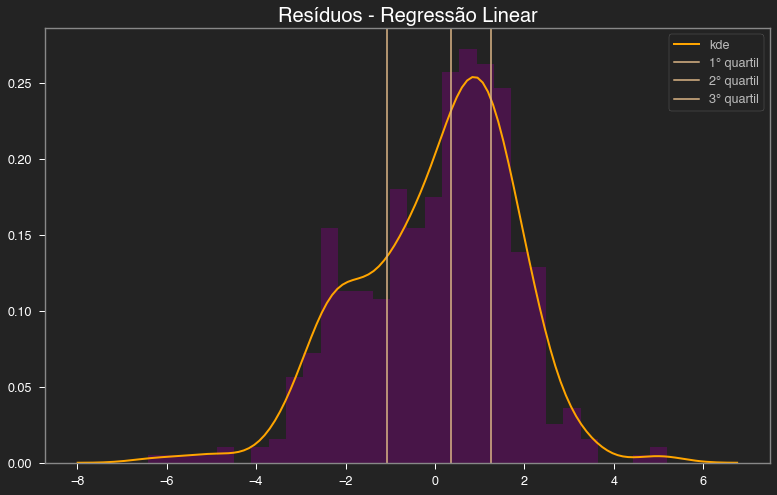

In [160]:
sns.distplot(est.resid,bins=30,color='purple',kde_kws={"color":"orange",'lw':2,'label':'kde'})
quantile = np.quantile(est.resid,[0.25,0.5,0.75])
for i in range(1,4):
    plt.axvline(x=quantile[i-1],color='burlywood',label=str(i)+'° quartil')
plt.legend()
plt.title('Resíduos - Regressão Linear');

### Testando premissas do modelo:

In [161]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(est.resid)
lzip(name, test)

[('Jarque-Bera', 21.755743241424582),
 ('Chi^2 two-tail prob.', 1.8871237495011354e-05),
 ('Skew', -0.47417524108305514),
 ('Kurtosis', 3.375162068584723)]

In [162]:
from statsmodels.tsa.stattools import adfuller
resid_mean = np.mean(est.resid)
adfuller_p = adfuller(est.resid)[1]

In [163]:
print("** Mean of the residuals: ", np.around(resid_mean,2))
print("\n** Jarque Bera Normality Test, p_value:", np.around(lzip(name, test)[0][1],3), "(>0.05, Normal)" if (lzip(name, test)[0][1]>0.05) else "(<0.05, Not-normal)")
print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")

** Mean of the residuals:  0.04

** Jarque Bera Normality Test, p_value: 21.756 (>0.05, Normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


In [164]:
from statsmodels.stats.stattools import durbin_watson
print('Assumption 4: No Autocorrelation', '\n')
print('Performing Durbin-Watson Test')
print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
print('0 to 2< is positive autocorrelation')
print('>2 to 4 is negative autocorrelation')
print('-------------------------------------')
durbinWatson = durbin_watson(est.resid)
print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

Assumption 4: No Autocorrelation 

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.621719606849272
Little to no autocorrelation 

Assumption satisfied


Ou seja, todas as premissas da regressão linear foram satisfeitas